In [29]:
# Dependencies
import tweepy
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime
import datetime
import time
import seaborn as sns
import pandas_datareader.data as web

In [30]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [31]:
# Twitter API Keys
from config import consumer_key, consumer_secret, \
    access_token, access_token_secret

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [32]:
# Filters
min_tweets = 5
lang = "en"

In [33]:
# Search terms
search_terms = ["$BMY", "$MRK", "$PFE", "$JNJ", "$CELG"]
search_terms1 = ["BMY", "MRK", "PFE", "JNJ", "CELG"]

# target_users = "@cnbc " or "@benzinga" or "@stocktwits"

# target_users = "@cnbc " or "@benzinga" or "@stocktwits" or "@breakoutstocks" \
#               or "@bespokeinvest" or "@WSJMarkets" or "@stephanie_link" or \
#              "@nytimesbusiness" or "@IBDinvestors " or "@WSJDealJournal"

In [34]:
# Date and time range
start = datetime.datetime(2018, 3, 7)
end = datetime.datetime(2018, 3, 9)

# Get Stock Data from Morningstar
stock_data = web.DataReader(search_terms1, "morningstar", start, end)

# Put Open and Close Data into Pandas DataFrame
df = pd.DataFrame(stock_data)[["Open", "Close"]]
df.head()

Open  Close
Symbol Date                    
BMY    2018-03-07  64.90  66.10
       2018-03-08  66.20  66.75
       2018-03-09  66.95  67.92
MRK    2018-03-07  53.84  54.47
       2018-03-08  54.52  54.76

In [35]:
df["Diff"] = df["Close"] - df["Open"]
#df.head()

df["Percent_Diff"] = (df["Diff"]/df["Open"])*100
df.head()

Open  Close  Diff  Percent_Diff
Symbol Date                                        
BMY    2018-03-07  64.90  66.10  1.20      1.848998
       2018-03-08  66.20  66.75  0.55      0.830816
       2018-03-09  66.95  67.92  0.97      1.448842
MRK    2018-03-07  53.84  54.47  0.63      1.170134
       2018-03-08  54.52  54.76  0.24      0.440205

In [36]:
# Calculate total stock price change within the date specified
df1 = df.groupby("Symbol")["Percent_Diff"].sum()
df1

Symbol
BMY     4.128657
CELG    3.391276
JNJ     4.308112
MRK     1.810230
PFE     2.781066
Name: Percent_Diff, dtype: float64

In [37]:
# Add data to Pandas DataFrame
df_df = pd.DataFrame(df1)
df_df

,Percent_Diff
Symbol,
BMY,4.128657
CELG,3.391276
JNJ,4.308112
MRK,1.810230
PFE,2.781066


In [38]:
# Reset index
diff_df = df_df.reset_index(drop = False)
diff_df

,Symbol,Percent_Diff
0,BMY,4.128657
1,CELG,3.391276
2,JNJ,4.308112
3,MRK,1.810230
4,PFE,2.781066


In [39]:
# Variables for holding sentiments
sentiments = []

In [40]:
# Date Range
startdate = datetime.datetime(2018, 3, 7, 0, 0, 0)
enddate = datetime.datetime(2018, 3, 9, 0, 0, 0)

# Loop through all search terms
for term in search_terms:
    
    counter = 1
    
    public_tweets = api.search(term, count = 200, since = startdate, until = enddate)
    
    for tweet in public_tweets["statuses"]:
        
        # Filter tweets
        if (tweet["user"]["statuses_count"] > min_tweets and
            tweet["user"]["lang"] == lang):
        
            # Run Vader Analysis on each tweets
            compound = analyzer.polarity_scores(tweet["text"])["compound"]
            pos = analyzer.polarity_scores(tweet["text"])["pos"]
            neu = analyzer.polarity_scores(tweet["text"])["neu"]
            neg = analyzer.polarity_scores(tweet["text"])["neg"]
            tweets_ago = counter

            # Add sentiments for each tweets into an array
            sentiments.append({"Compound": compound,
                               "Positive": pos,
                               "Neutral": neu,
                               "Negative": neg,
                               "Tweets Ago": counter,
                               "Symbol": term,
                               "Date": tweet["created_at"],
                               "Tweet Text": tweet["text"]})

        # Add to counter
        counter = counter + 1
        
sentiments

[{'Compound': 0.0,
  'Date': 'Thu Mar 08 11:55:03 +0000 2018',
  'Negative': 0.0,
  'Neutral': 1.0,
  'Positive': 0.0,
  'Symbol': '$BMY',
  'Tweet Text': 'Bank of America Increases Bristol-Myers Squibb $BMY Price Target to $68.00 https://t.co/CwwkASjorG',
  'Tweets Ago': 1},
 {'Compound': -0.5106,
  'Date': 'Wed Mar 07 17:28:47 +0000 2018',
  'Negative': 0.231,
  'Neutral': 0.769,
  'Positive': 0.0,
  'Symbol': '$BMY',
  'Tweet Text': '$BMY Max Pain is 66.00 for maturity 03/09/2018. #maxpain #options https://t.co/tIC4bRrxG2 https://t.co/9KYnTs2rvt',
  'Tweets Ago': 2},
 {'Compound': 0.0,
  'Date': 'Wed Mar 07 07:13:47 +0000 2018',
  'Negative': 0.0,
  'Neutral': 1.0,
  'Positive': 0.0,
  'Symbol': '$BMY',
  'Tweet Text': 'Bristol-Myers Squibb $BMY PT Raised to $68.00 at Bank of America https://t.co/898YB0R5yB',
  'Tweets Ago': 3},
 {'Compound': 0.0,
  'Date': 'Thu Mar 08 19:08:23 +0000 2018',
  'Negative': 0.0,
  'Neutral': 1.0,
  'Positive': 0.0,
  'Symbol': '$MRK',
  'Tweet Text': '

In [41]:
# Convert sentiments to DataFrame
sentiments_df = pd.DataFrame.from_dict(sentiments)
unique_sentiments_df = sentiments_df.drop_duplicates("Tweet Text", keep = "first")
unique_sentiments_df

,Compound,Date,Negative,Neutral,Positive,Symbol,Tweet Text,Tweets Ago
0,0.0000,Thu Mar 08 11:55:03 +0000 2018,0.000,1.000,0.000,$BMY,Bank of America Increases Bristol-Myers Squibb...,1
1,-0.5106,Wed Mar 07 17:28:47 +0000 2018,0.231,0.769,0.000,$BMY,$BMY Max Pain is 66.00 for maturity 03/09/2018...,2
2,0.0000,Wed Mar 07 07:13:47 +0000 2018,0.000,1.000,0.000,$BMY,Bristol-Myers Squibb $BMY PT Raised to $68.00 ...,3
3,0.0000,Thu Mar 08 19:08:23 +0000 2018,0.000,1.000,0.000,$MRK,BMO Capital Markets Analysts Give Merck &amp; ...,1
4,0.0000,Thu Mar 08 18:13:59 +0000 2018,0.000,1.000,0.000,$MRK,"Merck &amp; Co., Inc. $MRK Given a $65.00 Pric...",2
5,0.0000,Thu Mar 08 18:12:33 +0000 2018,0.000,1.000,0.000,$MRK,"Merck &amp; Co., Inc. $MRK Given a $65.00 Pric...",3
6,0.7269,Wed Mar 07 15:34:14 +0000 2018,0.000,0.711,0.289,$MRK,MRK continues to base near major support; http...,4
7,-0.5106,Wed Mar 07 12:35:08 +0000 2018,0.231,0.769,0.000,$MRK,$MRK Max Pain is 55.00 for maturity 03/09/2018...,5
8,0.0000,Thu Mar 08 09:21:29 +0000 2018,0.000,1.000,0.000,$PFE,Pfizer $PFE Given a $43.00 Price Target at BMO...,1
9,-0.5106,Wed Mar 07 18:20:08 +0000 2018,0.231,0.769,0.000,$PFE,$PFE Max Pain is 36.00 for maturity 03/09/2018...,2


In [42]:
# Groupby average compound sentiments by Symbol
ave_sentiment_by_company = unique_sentiments_df.groupby("Symbol")["Compound"].mean()
ave_sentiment_by_company

Symbol
$BMY    -0.17020
$CELG   -0.17020
$JNJ     0.00000
$MRK     0.04326
$PFE    -0.12765
Name: Compound, dtype: float64

In [43]:
# Add to Pandas Dataframe
ave_sentiment_by_company_df = pd.DataFrame(ave_sentiment_by_company)
ave_sentiment_by_company_df

,Compound
Symbol,
$BMY,-0.17020
$CELG,-0.17020
$JNJ,0.00000
$MRK,0.04326
$PFE,-0.12765


In [44]:
# Reset index
sentiment_df = ave_sentiment_by_company_df.reset_index(drop = False)
sentiment_df

,Symbol,Compound
0,$BMY,-0.17020
1,$CELG,-0.17020
2,$JNJ,0.00000
3,$MRK,0.04326
4,$PFE,-0.12765


In [45]:
final_sentiment_df = sentiment_df.replace(("$BMY", "$CELG", "$JNJ", "$MRK", "$PFE"), 
                                        ("BMY", "CELG", "JNJ", "MRK", "PFE"))

final_sentiment_df

,Symbol,Compound
0,BMY,-0.17020
1,CELG,-0.17020
2,JNJ,0.00000
3,MRK,0.04326
4,PFE,-0.12765


In [46]:
# merge dataframes
final_df = diff_df.merge(final_sentiment_df, how = "outer")
final_df
round(final_df, 3)

,Symbol,Percent_Diff,Compound
0,BMY,4.129,-0.170
1,CELG,3.391,-0.170
2,JNJ,4.308,0.000
3,MRK,1.810,0.043
4,PFE,2.781,-0.128


In [47]:
final_df.to_csv("table1.csv", index = False)

In [48]:
# Colors
colors = ["green", "red", "blue", "orange", "maroon"]

# Define x-axis and xlabels
x_axis = np.arange(len(final_df))
x_labels = diff_df.index

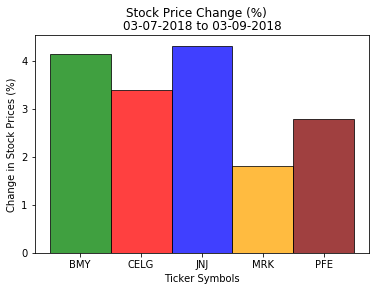

In [55]:
# Plot bar graph and assign appropriate parameters
plt.bar(x_axis, final_df["Percent_Diff"], width = 1, tick_label = x_labels,
        color = colors, alpha = 0.75, align = "edge", edgecolor = "black")

tick_locations = [i+0.5 for i in x_axis]
plt.xticks(tick_locations, ["BMY", "CELG", "JNJ", "MRK", "PFE"])

# Chart Title, x-label and y-label
plt.suptitle("Stock Price Change (%)")
plt.title("03-07-2018 to 03-09-2018")
plt.xlabel("Ticker Symbols")
plt.ylabel("Change in Stock Prices (%)")

# Export and save Bar plot
plt.savefig("PriceChange.png")

# Print chart to the screen
plt.show()

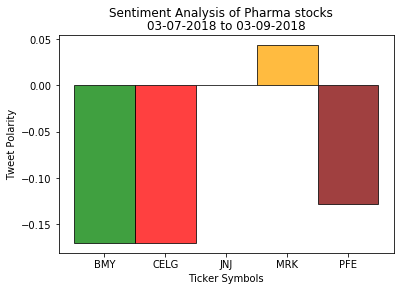

In [50]:
# Plot bar graph and assign appropriate parameters
plt.bar(x_axis, final_df["Compound"], width = 1, tick_label = x_labels,
        color = colors, alpha = 0.75, align = "edge", edgecolor = "black")

tick_locations = [i+0.5 for i in x_axis]
plt.xticks(tick_locations, ["BMY", "CELG", "JNJ", "MRK", "PFE"])

# Chart Title, x-label and y-label
plt.suptitle("Sentiment Analysis of Pharma stocks")
plt.title("03-07-2018 to 03-09-2018")
plt.xlabel("Ticker Symbols")
plt.ylabel("Tweet Polarity")

# Export and save Bar plot
plt.savefig("Sentiment.png")

# Print chart to the screen
plt.show()

In [51]:
corr = final_df["Percent_Diff"].corr(final_df["Compound"])
corr

-0.39433683070848308

In [52]:
x = final_df["Percent_Diff"]
y = final_df["Compound"]
fit = np.polyfit(x, y, 1)
fit_fn = np.poly1d(fit)
plt.plot(x, fit_fn(x), color = 'black')

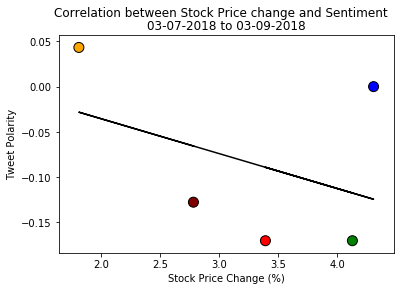

In [53]:
# Scatter Correlation plot
plt.scatter(final_df["Percent_Diff"], final_df["Compound"],
         s = 100, color = colors, edgecolor = "black")

plt.suptitle("Correlation between Stock Price change and Sentiment")
plt.title("03-07-2018 to 03-09-2018")
plt.xlabel("Stock Price Change (%)")
plt.ylabel("Tweet Polarity")

# Export and save scatter plot
plt.savefig("Correlation.png")

# Print chart to the screen
plt.show()

In [54]:
corr = final_df["Percent_Diff"].corr(final_df["Compound"])
corr

-0.39433683070848308